In [2]:
import pickle
import gc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as font_manager
import time
import datetime
from tqdm import tqdm
import os
import torch
import itertools
import math
import json
import csv
from scipy.stats import norm
from util.consts import linestyle_list
from textwrap import wrap
from util.consts import MTU,BDP,BDP_IN_BYTE,MTU_IN_BYTE,UNIT_G,P99_PERCENTILE_LIST,HEADER_SIZE,DELAY_PROPAGATION,BYTE_TO_BIT

In [3]:
P99_DIVIDENT = [np.arange(0, 6), np.arange(6, 9), np.arange(9, 10)]
SIZE_BUCKET_LIST = np.array(
    [MTU // 4, MTU // 2, MTU, 2 * MTU, 5 * MTU, BDP, 2 * BDP, 3 * BDP, 5 * BDP]
)
FLOWSIZE_BUCKET_DICT = {
    0: "<BDP",
    1: "(BDP, 10BDP]",
    2: ">10BDP",
}
SIZE_BIN_LIST = [BDP, 10 * BDP]
labels = FLOWSIZE_BUCKET_DICT
dir_input='/data2/lichenni/parsimon/input'
dir_output="/data2/lichenni/output_0916"
lr=10
color_list=[
    'blue',
    'red',
    'black'
]
def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
    enable_save=False,
    fig_idx=0
):
    _fontsize = fontsize
    fig = plt.figure(fig_idx,figsize=(5, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=3,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=3,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)
    if enable_save:
        plt.savefig(file_name, bbox_inches="tight", pad_inches=0)

_fontsize = 20
legend_font=20
x_len = len(SIZE_BUCKET_LIST) + 1
y_len = len(P99_PERCENTILE_LIST)

5.103s


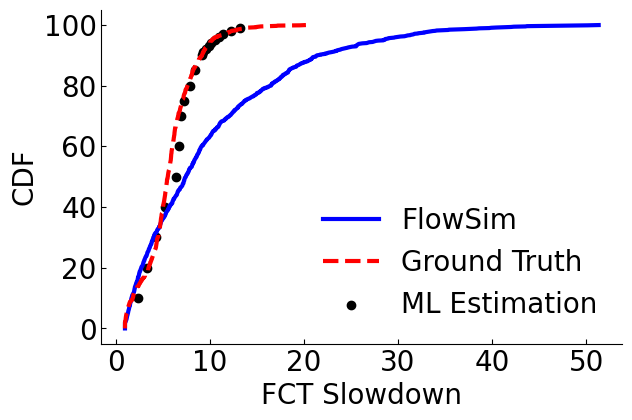

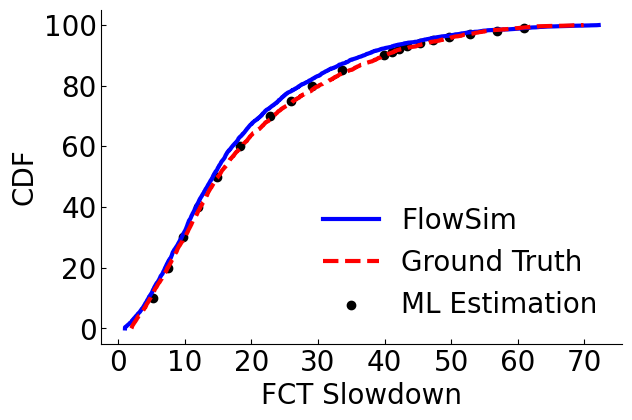

In [18]:
# [FINAL] fct: SLOWDOWN pareto_lognorm
# /data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_0/test/version_1/pareto_lognorm_util0.4_shard0_ias2.0_ss30000_lr10Gbps_nflows10000/res_k1.0_prop1.0.npz
# /data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_0/test/version_1/pareto_lognorm_util0.4_shard0_ias2.0_ss20000_lr10Gbps_nflows10000/res_k0.5_prop2.0.npz
# /data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_0/test/version_1/pareto_lognorm_util0.4_shard0_ias2.0_ss45000_lr10Gbps_nflows10000/res_k2.0_prop2.0.npz
# /data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_0/test/version_1/pareto_lognorm_util0.4_shard0_ias3.0_ss50000_lr10Gbps_nflows10000/res_k2.0_prop2.0.npz
data_list = ['pareto_lognorm_util0.4_shard0_ias3.0_ss50000_lr10Gbps_nflows10000']
fig_index=0
# dctcp_k_factor_list= [2.0]
# prop_delay_factor_list= [0.5,1.5,2.0]
# dctcp_k_factor_list_legend= ['6BDP']
# prop_delay_factor_list_legend= ['2Kns','6Kns','8Kns']

dctcp_k_factor_list= [2.0]
prop_delay_factor_list= [2.0]

dctcp_k_factor_list_legend= ['6BDP']
prop_delay_factor_list_legend= ['8Kns']

auxi_list=[f"_k{dctcp_k_factor}_prop{prop_delay_factor}" for dctcp_k_factor in dctcp_k_factor_list for prop_delay_factor in prop_delay_factor_list ]
auxi_list_legend=[f"_k{dctcp_k_factor}_prop{prop_delay_factor}" for dctcp_k_factor in dctcp_k_factor_list_legend for prop_delay_factor in prop_delay_factor_list_legend ]
y_label='CDF'
x_label='FCT Slowdown'

for spec in sorted(data_list):
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    i_fcts = np.load(f'{dir_input}/{spec}/i_fcts.npy')
    fcts = np.load(f'{dir_input}/{spec}/fcts.npy')
    # sldns = np.divide(fcts-4000, i_fcts-4000)
    sldns = np.divide(fcts, i_fcts)
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    var_list=[]
    for auxi in auxi_list:
        fct_var=np.load(f'{dir_input}/{spec}/fcts{auxi}.npy')
        i_fct_var=np.load(f'{dir_input}/{spec}/i_fcts{auxi}.npy')
        # prop_delay_factor=float(auxi.split("_")[2][4:])
        # print("prop_delay_factor:", prop_delay_factor)
        # sldns_var=np.divide(fct_var-4000*prop_delay_factor, i_fct_var-4000*prop_delay_factor)
        sldns_var=np.divide(fct_var, i_fct_var)
        var_list.append(sldns_var)
    
    var_list_est=[]
    dir_tmp="/data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_0/test"
    for auxi in auxi_list:
        data_path=f'{dir_tmp}/version_0/{spec}/res{auxi}.npz'
        if not os.path.exists(data_path):
            data_path=f'{dir_tmp}/version_1/{spec}/res{auxi}.npz'
        data = np.load(data_path)
        sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
        sizebucket_to_sldn_flowsim = data['sizebucket_to_sldn_flowsim']
        sizebucket_to_sldn = data['sizebucket_to_sldn']
        num_flows_per_cell = data['num_flows_per_cell']

        sizebucket_to_sldn_flowsim=sizebucket_to_sldn_flowsim.reshape(x_len,y_len)
        sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len,y_len)
        sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len,y_len)
        num_flows_per_cell=num_flows_per_cell.reshape(x_len,y_len)
        sizebucket_to_sldn_flowsim[sizebucket_to_sldn==0]=None
        sizebucket_to_sldn_est[sizebucket_to_sldn==0]=None
        sizebucket_to_sldn[sizebucket_to_sldn==0]=None
        
        for j in range(len(P99_DIVIDENT)):
            idx_tmp=P99_DIVIDENT[j]
            sum_tmp=np.sum(num_flows_per_cell[idx_tmp],axis=0)
            num_flows_per_cell[idx_tmp]=np.divide(num_flows_per_cell[idx_tmp],sum_tmp)
        
        sizebucket_to_sldn_est=np.array([
                            np.nansum(
                                np.multiply(sizebucket_to_sldn_est[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]),axis=0) 
                                    for j in range(len(P99_DIVIDENT))])
        var_list_est.append(sizebucket_to_sldn_est)

    fats = np.load(f'{dir_input}/{spec}/flow_arrival_times.npy')

    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")

    bins = np.digitize(sizes, SIZE_BIN_LIST)
                
    # weighted_sldns_var0 = np.divide(weighted_fcts_var0, i_fcts)

    # plt.suptitle(f"{spec}-{deq_time_max}s", fontsize="x-large")
    # for i in range(len(labels)):
    for i in [0,2]:
        gt = np.extract(bins==i, sldns)
        estimated_flowsim = np.extract(bins==i, sldns_flowsim)
        
        sldn_list=[]
        for var in var_list:
            sldn_list.append(np.extract(bins==i, var))
        
        sldn_list_est=[]
        for var_est in var_list_est:
            sldn_list_est.append(var_est[i])
        
        fig = plt.figure(fig_index,figsize=(6, 4))
        ax = fig.add_subplot(111)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis="y", direction="in")
        ax.tick_params(axis="x", direction="in")
        plt.ylabel(y_label, fontsize=_fontsize)
        plt.xlabel(x_label, fontsize=_fontsize)
        # linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    
        sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        
        plt.plot(np.sort(estimated_flowsim)[sample_list], (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100)[sample_list], label='FlowSim', color=color_list[0], linewidth=3)
        
        for sldn_idx in range(len(sldn_list)):
            sldn=sldn_list[sldn_idx]
            sldn_est=sldn_list_est[sldn_idx]
            plt.plot(np.sort(sldn)[sample_list], (np.arange(len(sldn))/len(sldn)*100)[sample_list], label=f'Ground Truth', linewidth=3,linestyle="--",color=color_list[sldn_idx+1])
            plt.scatter(sldn_est, P99_PERCENTILE_LIST,color=color_list[sldn_idx+2],label=f'ML Estimation')

        # plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        legend_properties = {"size": legend_font}
        plt.legend(
            prop=legend_properties,
            frameon=False,
            loc=4,
        )
        plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
        plt.yticks(fontsize=_fontsize)
        plt.xticks(fontsize=_fontsize)
        
        # plt.ylim([80, 100])
        # plt.savefig(f'./figs/workload_example_{fig_index}', bbox_inches="tight", pad_inches=0)
        fig_index+=1
        

1
3.6964493992471503,8.099488986275816,7.720696926116943
12.366828198027964,14.928009948507281,14.354147911071777


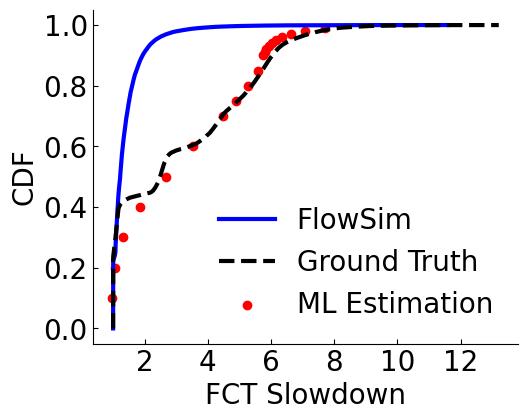

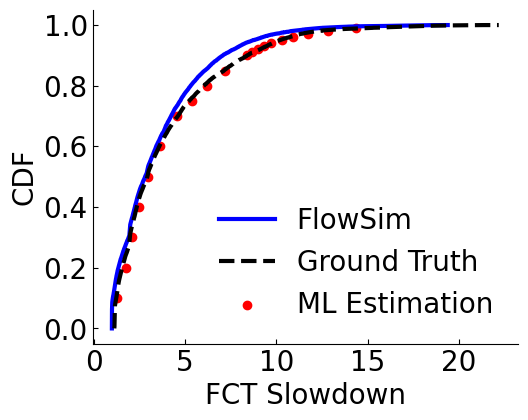

In [21]:
# [FINAL] CDF of slowdowns for different flow size buckets on empirial dataset
lr=10
sizesigma_list = [0]
iasigma_list = [2.0]
shard_list = [0]
n_flows_list=[100000]
# sizedist_list=["GoogleRPC2008", "AliStorage2019", "FbHdp_distribution","WebSearch_distribution"]
sizedist_list=["FbHdp_distribution"]
avg_util_list=[0.5]
data_list = []
for tag in sizedist_list:
    for avg_util in avg_util_list:
        for iasigma in iasigma_list:
            for sizesigma in sizesigma_list:
                for shard in shard_list:
                    for n_flows in n_flows_list:
                        data_list.append(
                            f"{tag}_lognorm_util{avg_util}_shard{shard}_ias{iasigma}_ss{sizesigma}_lr{lr}Gbps_nflows{n_flows}")
dir_input='/data2/lichenni/parsimon/input_empirical'
dir_output="/data2/lichenni/output_0916"
dir_train=f"{dir_output}/train_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_4/"
fig_index=0
enable_mean=False
y_label='CDF'
x_label='FCT Slowdown'
print(len(data_list))
for spec in sorted(data_list):
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    i_fcts = np.load(f'{dir_input}/{spec}/i_fcts.npy')
    fcts = np.load(f'{dir_input}/{spec}/fcts.npy')
    sldns = np.divide(fcts, i_fcts)
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    data_path=f'{dir_train}/test/version_2/{spec}/res.npz'
    data = np.load(data_path)
    sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
    sizebucket_to_sldn_flowsim = data['sizebucket_to_sldn_flowsim']
    sizebucket_to_sldn = data['sizebucket_to_sldn']
    num_flows_per_cell = data['num_flows_per_cell']

    sizebucket_to_sldn_flowsim=sizebucket_to_sldn_flowsim.reshape(x_len,y_len)
    sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len,y_len)
    sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len,y_len)
    num_flows_per_cell=num_flows_per_cell.reshape(x_len,y_len)
    sizebucket_to_sldn_flowsim[sizebucket_to_sldn==0]=None
    sizebucket_to_sldn_est[sizebucket_to_sldn==0]=None
    sizebucket_to_sldn[sizebucket_to_sldn==0]=None
    
    for j in range(len(P99_DIVIDENT)):
        idx_tmp=P99_DIVIDENT[j]
        sum_tmp=np.sum(num_flows_per_cell[idx_tmp],axis=0)
        num_flows_per_cell[idx_tmp]=np.divide(num_flows_per_cell[idx_tmp],sum_tmp)
    if not enable_mean:
        sizebucket_to_sldn=np.array([
                            np.nansum(
                                np.multiply(sizebucket_to_sldn[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]),axis=0) 
                                    for j in range(len(P99_DIVIDENT))])
        sizebucket_to_sldn_flowsim=np.array([
                            np.nansum(
                                np.multiply(sizebucket_to_sldn_flowsim[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]),axis=0) 
                                    for j in range(len(P99_DIVIDENT))])
        sizebucket_to_sldn_est=np.array([
                            np.nansum(
                                np.multiply(sizebucket_to_sldn_est[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]),axis=0) 
                                    for j in range(len(P99_DIVIDENT))])

    else:
        sizebucket_to_sldn=np.array([np.nanmean(sizebucket_to_sldn[P99_DIVIDENT[j]],axis=0) for j in range(len(P99_DIVIDENT)) if len(sizebucket_to_sldn[P99_DIVIDENT[j]])])
        
        sizebucket_to_sldn_flowsim=np.array([np.nanmean(sizebucket_to_sldn_flowsim[P99_DIVIDENT[j]],axis=0) for j in range(len(P99_DIVIDENT)) if len(sizebucket_to_sldn_flowsim[P99_DIVIDENT[j]])])
        
        sizebucket_to_sldn_est=np.array([np.nanmean(sizebucket_to_sldn_est[P99_DIVIDENT[j]],axis=0) for j in range(len(P99_DIVIDENT)) if len(sizebucket_to_sldn_est[P99_DIVIDENT[j]])])
    
    # print("sizebucket_to_sldn_est:",sizebucket_to_sldn_est.shape)
    
    # fats = np.load(f'{dir_input}/{spec}/flow_arrival_times.npy')

    # deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    # print(f"{deq_time_max}s")

    bins = np.digitize(sizes, SIZE_BIN_LIST)
                
    # weighted_sldns_var0 = np.divide(weighted_fcts_var0, i_fcts)

    # for i in range(len(FLOWSIZE_BUCKET_DICT)):
    for i in [0,2]:
        gt = np.extract(bins==i, sldns)
        estimated_flowsim = np.extract(bins==i, sldns_flowsim)
        
        var1 = sizebucket_to_sldn[i]
        var2 = sizebucket_to_sldn_flowsim[i]
        var3 = sizebucket_to_sldn_est[i]
        
        sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))

        fig = plt.figure(fig_index,figsize=(5, 4))
        ax = fig.add_subplot(111)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis="y", direction="in")
        ax.tick_params(axis="x", direction="in")
        plt.ylabel(y_label, fontsize=_fontsize)
        plt.xlabel(x_label, fontsize=_fontsize)
        
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        
        plt.plot(np.sort(estimated_flowsim)[sample_list], (np.arange(len(estimated_flowsim))/len(estimated_flowsim))[sample_list], label='FlowSim', color=color_list[0], linewidth=3)
        
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt))[sample_list], label=f'Ground Truth', linewidth=3,linestyle="--",color=color_list[sldn_idx+2])
        
        # plt.scatter(var1, P99_PERCENTILE_LIST, label='Parsimon-percentile')
        # plt.scatter(var2, P99_PERCENTILE_LIST, label='flowsim-percentile')
        plt.scatter(var3, P99_PERCENTILE_LIST/100, color=color_list[sldn_idx+1],label=f'ML Estimation')
        
        print(f"{np.nanpercentile(estimated_flowsim,99)},{np.nanpercentile(gt,99)},{var3[-1]}")
        legend_properties = {"size": legend_font}
        plt.legend(
            prop=legend_properties,
            frameon=False,
            loc=4,
        )
        plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
        plt.yticks(fontsize=_fontsize)
        plt.xticks(fontsize=_fontsize)
        
        # plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        # plt.legend()
        # plt.ylim([80, 100])
        plt.savefig(f'./figs/workload_example_{fig_index}', bbox_inches="tight", pad_inches=0)
        fig_index+=1


156
dir_train: /data2/lichenni/output_0916/train_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_0/
load 156 tracks
(4, 156)
[0.54222405 0.04898518 0.13839819 0.04785177]


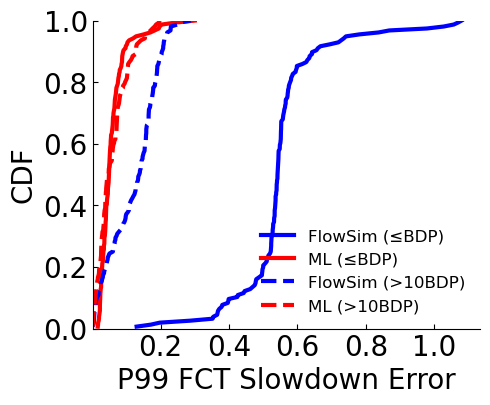

In [24]:
# cdf of p99 SLOWDOWN, trained on 10K flows for cwnd
dir_output="/data2/lichenni/output_0916"
program_name_list=['train_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1',]
version_id_list=[
    # [0,1,2,3,4],
    [0],
]

file_tag = "-abs"
enable_abs = True
# file_tag = ""
# enable_abs = False

data_list_empirical = []
shard=0
for tag in ["GoogleRPC2008", "AliStorage2019", "FbHdp_distribution","WebSearch_distribution"]:
    for avg_util in [0.1,0.15,0.2,0.25,0.3 ,0.35, 0.4,0.45, 0.5 ,0.55, 0.6 ,0.65,0.7]:
        for iasigma in [1.0,1.5,2.0]:
            for sizesigma in [0]:
                # for n_flows in [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]:
                for n_flows in [100000]:
                    data_list_empirical.append(
                        f"{tag}_lognorm_util{avg_util}_shard{shard}_ias{iasigma}_ss{sizesigma}_lr10Gbps_nflows{n_flows}"
                    )
                    
# for version_id in np.arange(10):
title_str_list = ["flowSim", "sizeBucket"]
main_title_list=['train','test','empirical']
enable_mean_list=[True,True,False,True,False]
print(len(data_list_empirical))
for program_name_idx,program_name in enumerate(program_name_list):
    for version_id in version_id_list[program_name_idx]:
        enable_mean=enable_mean_list[version_id]
        dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
        print(f"dir_train: {dir_train}")
        for version_id_test in [2]:
            if version_id_test!=2:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                if version_id_test==0:
                    data_list_test=data_list["train"]
                else:
                    data_list_test=data_list["test"]
            else:
                data_list_test=data_list_empirical
            len_tracks=len(data_list_test)
            print(f"load {len_tracks} tracks")
            res_p99=[]
            for spec in data_list_test:
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}/res.npz')
                sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
                sizebucket_to_sldn_flowsim = data['sizebucket_to_sldn_flowsim']
                sizebucket_to_sldn = data['sizebucket_to_sldn']
                num_flows_per_cell = data['num_flows_per_cell']

                sizebucket_to_sldn_flowsim=sizebucket_to_sldn_flowsim.reshape(x_len,y_len)
                sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len,y_len)
                sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len,y_len)
                sizebucket_to_sldn_flowsim[sizebucket_to_sldn==0]=None
                sizebucket_to_sldn_est[sizebucket_to_sldn==0]=None
                sizebucket_to_sldn[sizebucket_to_sldn==0]=None
            
                res=[np.divide((sizebucket_to_sldn_flowsim-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                        where=sizebucket_to_sldn != None),np.divide((sizebucket_to_sldn_est-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                            where=sizebucket_to_sldn != None)]
                # print(f'{spec}')
                res_cdf=[]
                for i in range(len(res)):
                    p99=res[i][:,-1]
                    if enable_abs:
                        p99=abs(p99)
                    if not enable_mean:
                        # print(p99)
                        res_cdf.extend([
                            len(P99_DIVIDENT[j])*np.nanmean(
                                np.multiply(p99[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]/np.sum(num_flows_per_cell[P99_DIVIDENT[j]]))
                                                ) 
                                    for j in range(len(P99_DIVIDENT)) if len(p99[P99_DIVIDENT[j]])])
                    else:
                        res_cdf.extend([
                            np.nanmean(
                                p99[P99_DIVIDENT[j]])
                                    for j in range(len(P99_DIVIDENT)) if len(p99[P99_DIVIDENT[j]])])
                # print(res_cdf)
                res_p99.append(res_cdf)
                # break
            res_p99=np.array(res_p99).transpose()
            # linelabels_list = []
            # for j in range(len(title_str_list)):
            #     for i in range(len(FLOWSIZE_BUCKET_DICT)):
            #         idx=j*len(FLOWSIZE_BUCKET_DICT)+i
            #         median_tmp=np.round(np.nanmedian(res_p99[idx]),3)
            #         linelabels_list.append(f"{FLOWSIZE_BUCKET_DICT[i]}-{title_str_list[j]}-"+"{:0.3f}".format(median_tmp))
            
            linelabels_list=['FlowSim (≤BDP)','ML (≤BDP)','FlowSim (>10BDP)','ML (>10BDP)',]
            res_p99=res_p99[[0,3,2,5]]
            print(res_p99.shape)
            print(np.nanmedian(res_p99,axis=1))
            plot_cdf(
                res_p99,
                f"./figs/workload_overall",
                linelabels_list,
                x_label="P99 FCT Slowdown Error",
                y_label="CDF",
                log_switch=False,
                rotate_xaxis=False,
                ylim_low=0,
                xlim=None,
                xlim_bottom=0.001,
                fontsize=20,
                legend_font=12,
                loc=4,
                # title=f"{main_title_list[version_id_test]}-{version_id}-{program_name}",
                title=None,
                enable_abs=enable_abs,
                group_size=2,
                enable_save=True
            )

0.978s
6.799037933349609 (7.140561185028959,)
7.915316581726074 (8.763639768804621,)
10.977564811706543 (12.316004825003416,)
10.731341361999512 (11.637317431270274,)
10.975193977355957 (12.047644119163918,)
10.238421440124512 (10.556706633392558,)


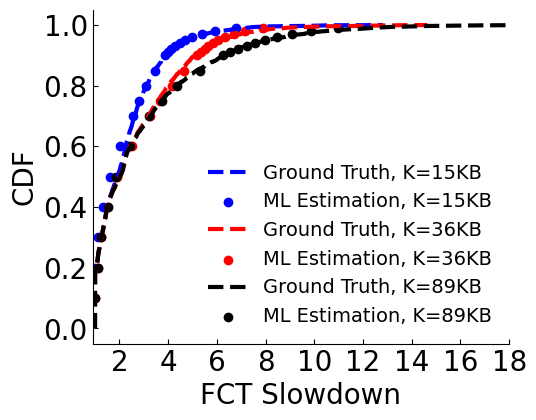

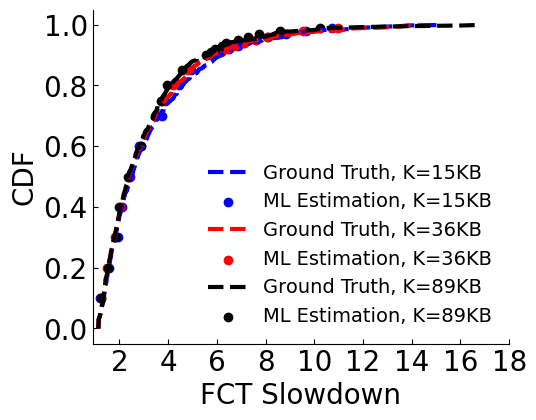

In [7]:
# fct: SLOWDOWN pareto_lognorm
dir_input='/data2/lichenni/parsimon/input'
dir_output="/data2/lichenni/output_0916"

data_list = ['pareto_lognorm_util0.4_shard0_ias2.0_ss20000_lr10Gbps_nflows10000']
fig_index=0
dctcp_k_factor_list= [0.508,1.229,2.977]
prop_delay_factor_list= [1.0]
_fontsize=20
dctcp_k_factor_list_legend= [f'{int(x*30)}KB' for x in dctcp_k_factor_list]
prop_delay_factor_list_legend= ['4Kns']

auxi_list=[f"_k{dctcp_k_factor}_prop{prop_delay_factor}" for dctcp_k_factor in dctcp_k_factor_list for prop_delay_factor in prop_delay_factor_list ]
auxi_list_legend=[f"{dctcp_k_factor}" for dctcp_k_factor in dctcp_k_factor_list_legend for prop_delay_factor in prop_delay_factor_list_legend ]
y_label='CDF'
x_label='FCT Slowdown'
for spec in sorted(data_list):
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    i_fcts = np.load(f'{dir_input}/{spec}/i_fcts.npy')
    fcts = np.load(f'{dir_input}/{spec}/fcts.npy')
    # sldns = np.divide(fcts-4000, i_fcts-4000)
    sldns = np.divide(fcts, i_fcts)
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    var_list=[]
    for auxi in auxi_list:
        fct_var=np.load(f'{dir_input}/{spec}/fcts{auxi}.npy')
        i_fct_var=np.load(f'{dir_input}/{spec}/i_fcts{auxi}.npy')
        # prop_delay_factor=float(auxi.split("_")[2][4:])
        # print("prop_delay_factor:", prop_delay_factor)
        # sldns_var=np.divide(fct_var-4000*prop_delay_factor, i_fct_var-4000*prop_delay_factor)
        sldns_var=np.divide(fct_var, i_fct_var)
        var_list.append(sldns_var)
    
    var_list_est=[]
    dir_tmp="/data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_5/test"
    for auxi in auxi_list:
        data_path=f'{dir_tmp}/version_2/{spec}/res{auxi}.npz'
        data = np.load(data_path)
        sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
        sizebucket_to_sldn_flowsim = data['sizebucket_to_sldn_flowsim']
        sizebucket_to_sldn = data['sizebucket_to_sldn']
        num_flows_per_cell = data['num_flows_per_cell']
        x_len = len(SIZE_BUCKET_LIST) + 1
        y_len = len(P99_PERCENTILE_LIST)

        sizebucket_to_sldn_flowsim=sizebucket_to_sldn_flowsim.reshape(x_len,y_len)
        sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len,y_len)
        sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len,y_len)
        num_flows_per_cell=num_flows_per_cell.reshape(x_len,y_len)
        sizebucket_to_sldn_flowsim[sizebucket_to_sldn==0]=None
        sizebucket_to_sldn_est[sizebucket_to_sldn==0]=None
        sizebucket_to_sldn[sizebucket_to_sldn==0]=None
        
        for j in range(len(P99_DIVIDENT)):
            idx_tmp=P99_DIVIDENT[j]
            sum_tmp=np.sum(num_flows_per_cell[idx_tmp],axis=0)
            num_flows_per_cell[idx_tmp]=np.divide(num_flows_per_cell[idx_tmp],sum_tmp)
        
        sizebucket_to_sldn_est=np.array([
                            np.nansum(
                                np.multiply(sizebucket_to_sldn_est[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]),axis=0) 
                                    for j in range(len(P99_DIVIDENT))])
        var_list_est.append(sizebucket_to_sldn_est)

    fats = np.load(f'{dir_input}/{spec}/flow_arrival_times.npy')

    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")

    bins = np.digitize(sizes, SIZE_BIN_LIST)
                
    # weighted_sldns_var0 = np.divide(weighted_fcts_var0, i_fcts)

    # for i in range(len(labels)):
    for i in [0,2]:
        gt = np.extract(bins==i, sldns)
        estimated_flowsim = np.extract(bins==i, sldns_flowsim)
        
        sldn_list=[]
        for var in var_list:
            sldn_list.append(np.extract(bins==i, var))
        
        sldn_list_est=[]
        for var_est in var_list_est:
            sldn_list_est.append(var_est[i])
        
        fig = plt.figure(fig_index,figsize=(5, 4))
        ax = fig.add_subplot(111)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis="y", direction="in")
        ax.tick_params(axis="x", direction="in")
        plt.ylabel(y_label, fontsize=_fontsize)
        plt.xlabel(x_label, fontsize=_fontsize)
        
        sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))

        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        # plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label='Parsimon', color='blue', linewidth=3)
        # plt.plot(np.sort(estimated_flowsim)[sample_list], (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100)[sample_list], label='flowsim', color='red', linewidth=3)
        
        for sldn_idx in range(len(sldn_list)):
            sldn=sldn_list[sldn_idx]
            sldn_est=sldn_list_est[sldn_idx]
            plt.plot(np.sort(sldn)[sample_list], (np.arange(len(sldn))/len(sldn))[sample_list], label=f'Ground Truth, K={auxi_list_legend[sldn_idx]}', linewidth=3,linestyle="--",color=color_list[sldn_idx])
            plt.scatter(sldn_est, P99_PERCENTILE_LIST/100,color=color_list[sldn_idx],label=f'ML Estimation, K={auxi_list_legend[sldn_idx]}')
            print(f"{sldn_est[-1]} ({np.nanpercentile(sldn,99)},)")
        # plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        legend_properties = {"size": 14}
        plt.legend(
            prop=legend_properties,
            frameon=False,
            loc=4,
        )
        plt.xlim(left=0.9,right=18)
        plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
        plt.yticks(fontsize=_fontsize)
        plt.xticks(fontsize=_fontsize)
        
        # plt.ylim([80, 100])
        plt.savefig(f'./figs/param_example_{fig_index}', bbox_inches="tight", pad_inches=0)
        fig_index+=1

dir_train: /data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_5/
load 38400 tracks


/tmp/ipykernel_491416/2633649444.py:130: RuntimeWarning: Mean of empty slice
  len(P99_DIVIDENT[j])*np.nanmean(
/tmp/ipykernel_491416/2633649444.py:131: RuntimeWarning: invalid value encountered in divide
  np.multiply(p99[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]/np.sum(num_flows_per_cell[P99_DIVIDENT[j]]))


[0.06467885502769648, 0.0477458586497267, 0.046308377285510814, 0.04622676879227497, 0.04606952184119672, 0.04643368972903686, 0.04681502577629241, 0.04677131440946271, 0.04752339940378512, 0.04869721880619354]
[0.06052186191159118, 0.05191284950510067, 0.049143067171579936, 0.048304223461411055, 0.047989332869709266, 0.045130255051759605, 0.04329070296713174, 0.042901195827945195, 0.042911678410983235, 0.04324046805019558]


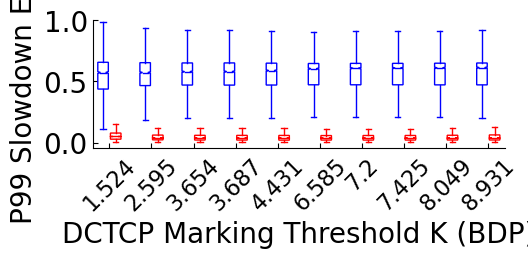

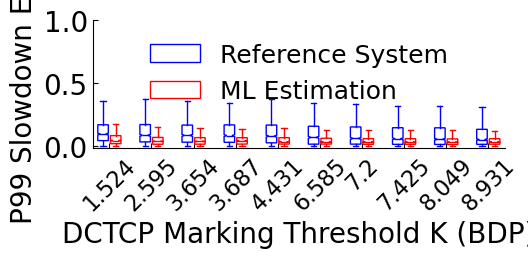

In [19]:
# [FINAL] cdf of p99 SLOWDOWN, trained on 10K flows for param
from collections import defaultdict
program_name_list=['train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1',]
version_id_list=[
    # [0,1,2,3,4],
    [5],
]
UTIL_LIST = [
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.35,
    0.4,
    0.45,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    # 0.85,
    # 0.9,
]
IAS_LIST = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
N_FLOWS_LIST = np.arange(10000, 100001, 10000)
SS_LIST=np.arange(5000, 50001, 5000)
dctcp_k_factor_list = [
                    0.508,
                    0.865,
                    1.218,
                    1.229,
                    1.477,
                    2.195,
                    2.4,
                    2.475,
                    2.683,
                    2.977,
                ]
param_list = [
    f"_k{dctcp_k_factor}_prop1.0_p"
    for dctcp_k_factor in dctcp_k_factor_list
]
data_list_param = []
for tag in [
    "pareto_lognorm",
    "gaussian_lognorm",
    "lognorm_lognorm",
    "exp_lognorm",
]:
    for avg_util in UTIL_LIST:
        for iasigma in IAS_LIST:
            for sizesigma in SS_LIST:
                for n_flows in [10000]:
                    for param in param_list:
                        data_list_param.append(
                            f"{tag}_util{avg_util}_shard0_ias{iasigma}_ss{sizesigma}_lr10Gbps_nflows{n_flows}{param}"
                        )
                        
file_tag = "-abs"
enable_abs = True
# file_tag = ""
# enable_abs = False

# for version_id in np.arange(10):
main_title_list=['Train Dataset: 42400 Scenarios','Test Dataset: 5120 Scenarios','Interpolation Dataset: 43200 Scenarios']
enable_mean_list=[False,False,False,False,False,False]
fig_index=0
y_label='P99 FCT Slowdown Error'
x_label='DCTCP Marking Threshold K (BDP)'
for program_name_idx,program_name in enumerate(program_name_list):
    for version_id in version_id_list[program_name_idx]:
        enable_mean=enable_mean_list[version_id]
        dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
        print(f"dir_train: {dir_train}")
        for version_id_test in [2]:
        # for version_id_test in [1]:
            if version_id_test!=2:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                if version_id_test==0:
                    data_list_test=data_list["train"]
                else:
                    data_list_test=data_list["test"]
            else:
                data_list_test=data_list_param
            len_tracks=len(data_list_test)
            print(f"load {len_tracks} tracks")
            res_p99_flowsim=defaultdict(lambda:[])
            res_p99_est=defaultdict(lambda:[])
            for spec in data_list_test:
                if spec[-1]=="p":
                    tmp=spec.split("_")
                    dctcp_k_factor=float(tmp[-3][1:])
                    prop_delay_factor=float(tmp[-2][4:])
                    spec="_".join([tmp[i] for i in range(len(tmp)-3)])
                    dir_param=f'_k{dctcp_k_factor}_prop{prop_delay_factor}'
                else:
                    dctcp_k_factor=1.0
                    prop_delay_factor=1.0
                    dir_param=f'' 
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}/res{dir_param}.npz')
                sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
                sizebucket_to_sldn_flowsim = data['sizebucket_to_sldn_flowsim']
                sizebucket_to_sldn = data['sizebucket_to_sldn']
                num_flows_per_cell = data['num_flows_per_cell']

                sizebucket_to_sldn_flowsim=sizebucket_to_sldn_flowsim.reshape(x_len,y_len)
                sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len,y_len)
                sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len,y_len)
                sizebucket_to_sldn_flowsim[sizebucket_to_sldn==0]=None
                sizebucket_to_sldn_est[sizebucket_to_sldn==0]=None
                sizebucket_to_sldn[sizebucket_to_sldn==0]=None
            
                res=[np.divide((sizebucket_to_sldn_flowsim-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                        where=sizebucket_to_sldn != None),np.divide((sizebucket_to_sldn_est-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                                where=sizebucket_to_sldn != None)]
                # print(f'{spec}')
                res_cdf=[]
                for i in range(len(res)):
                    p99=res[i][:,-1]
                    if enable_abs:
                        p99=abs(p99)
                    if not enable_mean:
                        # print(p99)
                        res_cdf.append([
                            len(P99_DIVIDENT[j])*np.nanmean(
                                np.multiply(p99[P99_DIVIDENT[j]],num_flows_per_cell[P99_DIVIDENT[j]]/np.sum(num_flows_per_cell[P99_DIVIDENT[j]]))
                                                ) 
                                    for j in range(len(P99_DIVIDENT)) if len(p99[P99_DIVIDENT[j]])])
                    else:
                        res_cdf.append([
                            np.nanmean(
                                p99[P99_DIVIDENT[j]])
                                    for j in range(len(P99_DIVIDENT)) if len(p99[P99_DIVIDENT[j]])])
                # print(res_cdf)
                res_p99_flowsim[dctcp_k_factor].append(res_cdf[0])
                res_p99_est[dctcp_k_factor].append(res_cdf[1])
                # break
            for key in res_p99_flowsim:
                res_p99_flowsim[key]=np.array(res_p99_flowsim[key]).transpose()
                res_p99_est[key]=np.array(res_p99_est[key]).transpose()
            x_lable_list=sorted(list(res_p99_flowsim.keys()))
            x_lable_list_xtick= [f'{np.round(x*3,3)}' for x in x_lable_list]
            n_lable=len(x_lable_list)
            x_tick=np.arange(1,len(x_lable_list)+1)*2
            for i in [0,2]:
                fig = plt.figure(fig_index,figsize=(5, 4))
                ax = fig.add_subplot(111)
                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)
                ax.tick_params(axis="y", direction="in")
                ax.tick_params(axis="x", direction="in")
                plt.ylabel(y_label, fontsize=_fontsize)
                plt.xlabel(x_label, fontsize=_fontsize)
        
                c = "blue"
                data=[res_p99_flowsim[key][i] for key in x_lable_list]
                data=[x[~np.isnan(x)] for x in data]
                bp2=plt.boxplot(data, positions=x_tick-0.3,notch=True, patch_artist=True,showfliers=False)
                for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                        plt.setp(bp2[item], color=c)
                for patch in bp2['boxes']:
                    patch.set(facecolor='white') 
                    
                c = "red"
                data=[res_p99_est[key][i] for key in x_lable_list]
                data=[x[~np.isnan(x)] for x in data]
                
                print([np.mean(x) for x in data])
                bp1=plt.boxplot(data, positions=x_tick+0.3,notch=True, patch_artist=True,showfliers=False)
                for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                        plt.setp(bp1[item], color=c)
                for patch in bp1['boxes']:
                    patch.set(facecolor='white') 
                # box1 = plt.boxplot(data, positions=x_tick, notch=True, patch_artist=True)
                # for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                #         plt.setp(box1[item], color=c2)
                # plt.setp(box1["boxes"], facecolor=c2)
                # plt.setp(box1["fliers"], markeredgecolor=c2)

                plt.xticks(x_tick, x_lable_list_xtick)
                # plt.plot(np.sort(sldn)[sample_list], (np.arange(len(sldn))/len(sldn)*100)[sample_list], label=f'Parsimon{auxi_list_legend[sldn_idx]}', linewidth=2,linestyle="--")
                # plt.scatter(sldn_est, P99_PERCENTILE_LIST)

                
                if fig_index!=0:
                    legend_properties = {"size": 18}
                    plt.legend(
                        [bp2["boxes"][0], bp1["boxes"][0]], ['FlowSim', 'ML Estimation'], 
                        prop=legend_properties,
                        frameon=False,
                        loc=9,
                        ncol=1
                    )
                plt.ylim(top=1.0)
                plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
                plt.yticks(fontsize=_fontsize)
                plt.xticks(fontsize=16)
                plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment="center")
                
                # plt.ylim([80, 100])
                plt.savefig(f'./figs/param_overall_{i}', bbox_inches="tight", pad_inches=0)
                fig_index+=1

dir_train: /data2/lichenni/output_0916/train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1/version_5/
load 15600 tracks


/tmp/ipykernel_2658050/2587964981.py:133: RuntimeWarning: invalid value encountered in divide
  np.multiply(p99[P99_DIVIDENT_TMP[j]],num_flows_per_cell[P99_DIVIDENT_TMP[j]]/np.sum(num_flows_per_cell[P99_DIVIDENT_TMP[j]]))
/tmp/ipykernel_2658050/2587964981.py:132: RuntimeWarning: Mean of empty slice
  len(P99_DIVIDENT_TMP[j])*np.nanmean(


[0.4058966785669327, 0.40796589106321335, 0.41678808629512787, 0.41978437453508377, 0.4248608276247978, 0.42148638516664505, 0.4222135618329048, 0.4201389104127884, 0.4209582507610321, 0.418437197804451]
0.11297408491373062
0.7321526855230331
[0.053034452721476555, 0.04421319346874952, 0.043027312494814396, 0.042871502228081226, 0.042652240954339504, 0.04234558902680874, 0.04284173250198364, 0.0424825306981802, 0.043400353752076626, 0.04383767955005169]
0.00246081268414855
0.1246553286910057


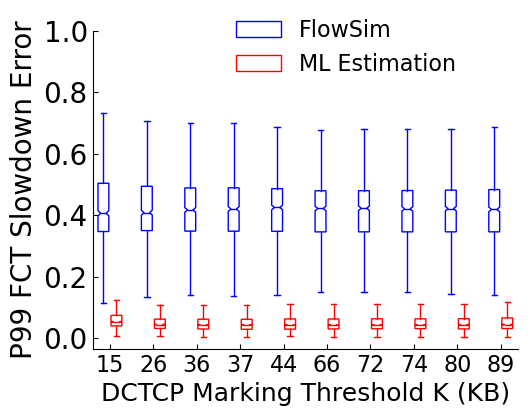

In [5]:
# [FINAL] cdf of p99 SLOWDOWN, trained on 10K flows for param
from collections import defaultdict
program_name_list=['train_param_tag4_util18_shard0_ias6_ss10_lr10Gbps_nflows1',]
version_id_list=[
    # [0,1,2,3,4],
    [5],
]
UTIL_LIST = [
    # 0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.35,
    0.4,
    0.45,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    # 0.75,
    # 0.8,
    # 0.85,
    # 0.9,
]
IAS_LIST = [1.0, 1.5, 2.0]
# N_FLOWS_LIST = np.arange(10000, 100001, 10000)
N_FLOWS_LIST = [100000]
SS_LIST=np.arange(5000, 50001, 5000)
dctcp_k_factor_list = [
                    0.508,
                    0.865,
                    1.218,
                    1.229,
                    1.477,
                    2.195,
                    2.4,
                    2.475,
                    2.683,
                    2.977,
                ]
param_list = [
    f"_k{dctcp_k_factor}_prop1.0_p"
    for dctcp_k_factor in dctcp_k_factor_list
]
data_list_param = []
for tag in [
    "pareto_lognorm",
    "gaussian_lognorm",
    "lognorm_lognorm",
    "exp_lognorm",
]:
    for avg_util in UTIL_LIST:
        for iasigma in IAS_LIST:
            for sizesigma in SS_LIST:
                for n_flows in [10000]:
                    for param in param_list:
                        data_list_param.append(
                            f"{tag}_util{avg_util}_shard0_ias{iasigma}_ss{sizesigma}_lr10Gbps_nflows{n_flows}{param}"
                        )
                        
file_tag = "-abs"
enable_abs = True
# file_tag = ""
# enable_abs = False

# for version_id in np.arange(10):
main_title_list=['Train Dataset: 42400 Scenarios','Test Dataset: 5120 Scenarios','Interpolation Dataset: 43200 Scenarios']
enable_mean_list=[False,False,False,False,False,False]
fig_index=0
y_label='P99 FCT Slowdown Error'
x_label='DCTCP Marking Threshold K (KB)'
P99_DIVIDENT_TMP=[np.arange(0, 10)]
for program_name_idx,program_name in enumerate(program_name_list):
    for version_id in version_id_list[program_name_idx]:
        enable_mean=enable_mean_list[version_id]
        dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
        print(f"dir_train: {dir_train}")
        for version_id_test in [2]:
        # for version_id_test in [1]:
            if version_id_test!=2:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                if version_id_test==0:
                    data_list_test=data_list["train"]
                else:
                    data_list_test=data_list["test"]
            else:
                data_list_test=data_list_param
            len_tracks=len(data_list_test)
            print(f"load {len_tracks} tracks")
            res_p99_flowsim=defaultdict(lambda:[])
            res_p99_est=defaultdict(lambda:[])
            for spec in data_list_test:
                if spec[-1]=="p":
                    tmp=spec.split("_")
                    dctcp_k_factor=float(tmp[-3][1:])
                    prop_delay_factor=float(tmp[-2][4:])
                    spec="_".join([tmp[i] for i in range(len(tmp)-3)])
                    dir_param=f'_k{dctcp_k_factor}_prop{prop_delay_factor}'
                else:
                    dctcp_k_factor=1.0
                    prop_delay_factor=1.0
                    dir_param=f'' 
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}/res{dir_param}.npz')
                sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
                sizebucket_to_sldn_flowsim = data['sizebucket_to_sldn_flowsim']
                sizebucket_to_sldn = data['sizebucket_to_sldn']
                num_flows_per_cell = data['num_flows_per_cell']

                sizebucket_to_sldn_flowsim=sizebucket_to_sldn_flowsim.reshape(x_len,y_len)
                sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len,y_len)
                sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len,y_len)
                sizebucket_to_sldn_flowsim[sizebucket_to_sldn==0]=None
                sizebucket_to_sldn_est[sizebucket_to_sldn==0]=None
                sizebucket_to_sldn[sizebucket_to_sldn==0]=None
            
                res=[np.divide((sizebucket_to_sldn_flowsim-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                        where=sizebucket_to_sldn != None),np.divide((sizebucket_to_sldn_est-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                                where=sizebucket_to_sldn != None)]
                # print(f'{spec}')
                res_cdf=[]
                for i in range(len(res)):
                    p99=res[i][:,-1]
                    if enable_abs:
                        p99=abs(p99)
                    if not enable_mean:
                        # print(p99)
                        res_cdf.append([
                            len(P99_DIVIDENT_TMP[j])*np.nanmean(
                                np.multiply(p99[P99_DIVIDENT_TMP[j]],num_flows_per_cell[P99_DIVIDENT_TMP[j]]/np.sum(num_flows_per_cell[P99_DIVIDENT_TMP[j]]))
                                                ) 
                                    for j in range(len(P99_DIVIDENT_TMP)) if len(p99[P99_DIVIDENT_TMP[j]])])
                    else:
                        res_cdf.append([
                            np.nanmean(
                                p99[P99_DIVIDENT_TMP[j]])
                                    for j in range(len(P99_DIVIDENT_TMP)) if len(p99[P99_DIVIDENT_TMP[j]])])
                # print(res_cdf)
                res_p99_flowsim[dctcp_k_factor].append(res_cdf[0])
                res_p99_est[dctcp_k_factor].append(res_cdf[1])
                # break
            for key in res_p99_flowsim:
                res_p99_flowsim[key]=np.array(res_p99_flowsim[key]).transpose()
                res_p99_est[key]=np.array(res_p99_est[key]).transpose()
            x_lable_list=sorted(list(res_p99_flowsim.keys()))
            x_lable_list_xtick= ['{:.0f}'.format(x*30) for x in x_lable_list]
            x_lable_list_xtick[2]=36
            n_lable=len(x_lable_list)
            x_tick=np.arange(1,len(x_lable_list)+1)*2
            for i in [0]:
                fig = plt.figure(fig_index,figsize=(5, 4))
                ax = fig.add_subplot(111)
                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)
                ax.tick_params(axis="y", direction="in")
                ax.tick_params(axis="x", direction="in")
                plt.ylabel(y_label, fontsize=_fontsize)
                plt.xlabel(x_label, fontsize=18)
        
                c = "blue"
                data=[res_p99_flowsim[key][i] for key in x_lable_list]
                data=[x[~np.isnan(x)] for x in data]
                bp2=plt.boxplot(data, positions=x_tick-0.3,notch=True, patch_artist=True,showfliers=False)
                for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                        plt.setp(bp2[item], color=c)
                for patch in bp2['boxes']:
                    patch.set(facecolor='white') 
                
                print([np.nanmedian(x) for x in data])
                print(np.nanmin([bp2['whiskers'][(i*2)].get_ydata()[1]for i in range(10)]))
                print(np.nanmax([bp2['whiskers'][(i*2)+1].get_ydata()[1]for i in range(10)]))
                
                c = "red"
                data=[res_p99_est[key][i] for key in x_lable_list]
                data=[x[~np.isnan(x)] for x in data]
                
                
                bp1=plt.boxplot(data, positions=x_tick+0.3,notch=True, patch_artist=True,showfliers=False)
                for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                        plt.setp(bp1[item], color=c)
                for patch in bp1['boxes']:
                    patch.set(facecolor='white') 
                print([np.nanmedian(x) for x in data])
                print(np.nanmin([bp1['whiskers'][(i*2)].get_ydata()[1]for i in range(10)]))
                print(np.nanmax([bp1['whiskers'][(i*2)+1].get_ydata()[1]for i in range(10)]))
                # box1 = plt.boxplot(data, positions=x_tick, notch=True, patch_artist=True)
                # for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                #         plt.setp(box1[item], color=c2)
                # plt.setp(box1["boxes"], facecolor=c2)
                # plt.setp(box1["fliers"], markeredgecolor=c2)

                plt.xticks(x_tick, x_lable_list_xtick)
                # plt.plot(np.sort(sldn)[sample_list], (np.arange(len(sldn))/len(sldn)*100)[sample_list], label=f'Parsimon{auxi_list_legend[sldn_idx]}', linewidth=2,linestyle="--")
                # plt.scatter(sldn_est, P99_PERCENTILE_LIST)

                
                legend_properties = {"size": 16}
                plt.legend(
                    [bp2["boxes"][0], bp1["boxes"][0]], ['FlowSim', 'ML Estimation'], 
                    prop=legend_properties,
                    frameon=False,
                    # loc=9,
                    loc='upper right', bbox_to_anchor=(0.9, 1.1),
                    ncol=1
                )
                plt.ylim(top=1.0)
                plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
                plt.yticks(fontsize=_fontsize)
                plt.xticks(fontsize=16)
                plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment="center")
                
                # plt.ylim([80, 100])
                plt.savefig(f'./figs/param_overall', bbox_inches="tight", pad_inches=0)
                fig_index+=1